In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [54]:
import keras
from keras.layers import  *
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils import plot_model
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Layer
K.set_image_data_format('channels_first')
import numpy as np
from keras.callbacks import *
import matplotlib.pyplot as plt


In [2]:
NUM_EPOCHS = 2000
LR = 0.001
DO_RATE = 0.1
BN_M = 0.9

BATCH_SIZE = 350
MAX_LENGTH = 16
PARAM_SIZE = 120
NUM_OFFSETS = 1 
DATA_SHAPE = (16,96,96)

In [41]:

y_samples = np.load('samples.npy')
y_lengths = np.load('lengths.npy')
num_samples = y_samples.shape[0]
num_songs = y_lengths.shape[0]

x_shape = (num_songs * NUM_OFFSETS, 1)
y_shape = (num_songs * NUM_OFFSETS, MAX_LENGTH) + y_samples.shape[1:]
x_orig = np.expand_dims(np.arange(x_shape[0]), axis=-1)
y_orig = np.zeros(y_shape, dtype=y_samples.dtype)

# Paddding short songs
cur_ix = 0
for i in range(num_songs):
    for ofs in range(NUM_OFFSETS):
        ix = i*NUM_OFFSETS + ofs
        end_ix = cur_ix + y_lengths[i]
        for j in range(MAX_LENGTH):
            k = (j + ofs) % (end_ix - cur_ix)
            y_orig[ix,j] = y_samples[cur_ix + k]
    cur_ix = end_ix
x_train = np.copy(x_orig)
y_train = np.copy(y_orig)

In [18]:
x_in = Input(shape=DATA_SHAPE)
x = Reshape((DATA_SHAPE[0], -1))(x_in)
x = TimeDistributed(Dense(2000, activation='relu'))(x)
x = TimeDistributed(Dense(200, activation='relu'))(x)
x = Flatten()(x)
x = Dense(1600, activation='relu')(x)
x = Dense(PARAM_SIZE)(x)
x = BatchNormalization(momentum=BN_M, name='pre_encoder')(x)
x = Dense(1600, name='encoder')(x)
x = BatchNormalization(momentum=BN_M)(x)
x = Activation('relu')(x)
x = Dropout(DO_RATE)(x)

x = Dense(MAX_LENGTH * 200)(x)
x = Reshape((MAX_LENGTH, 200))(x)
x = TimeDistributed(BatchNormalization(momentum=BN_M))(x)
x = Activation('relu')(x)

x = Dropout(DO_RATE)(x)

x = TimeDistributed(Dense(2000))(x)
x = TimeDistributed(BatchNormalization(momentum=BN_M))(x)
x = Activation('relu')(x)
x = Dropout(DO_RATE)(x)

x = TimeDistributed(Dense(DATA_SHAPE[1] * DATA_SHAPE[2], activation='sigmoid'))(x)
x = Reshape(DATA_SHAPE)(x)

model = Model(x_in, x)
model.compile(optimizer=RMSprop(lr=LR), loss='binary_crossentropy')


In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 96, 96)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 9216)          0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 2000)          18434000  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 200)           400200    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1600)              5121600   
_________________________________________________________________
dense_10 (Dense)             (None, 120)               1921

In [52]:
filepath = "weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

history = model.fit(y_train, y_train, batch_size=BATCH_SIZE, epochs=2000)

Epoch 1/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 2/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 3/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 4/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 5/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 6/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 7/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 8/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0130
Epoch 9/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 10/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0126
Epoch 11/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 12/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0122
E

Epoch 99/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0076
Epoch 100/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 101/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 102/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 103/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 104/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 105/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 106/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 107/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 108/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 109/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0076
Epoch 110/2000
334/334 [==============================] - 1s 2ms/s

Epoch 196/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 197/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 198/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 199/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 200/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 201/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 202/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 203/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 204/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 205/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 206/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 207/2000
334/334 [==============================] - 1s 2ms/

Epoch 293/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 294/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 295/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 296/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 297/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 298/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 299/2000
334/334 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 300/2000
334/334 [==============================] - 1s 2ms/step - loss: 9.9654e-04
Epoch 301/2000
334/334 [==============================] - 1s 2ms/step - loss: 9.9374e-04
Epoch 302/2000
334/334 [==============================] - 1s 2ms/step - loss: 9.8555e-04
Epoch 303/2000
334/334 [==============================] - 1s 2ms/step - loss: 9.8942e-04
Epoch 304/2000
334/334 [=========================

Epoch 386/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1686e-04
Epoch 387/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1269e-04
Epoch 388/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1398e-04
Epoch 389/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1199e-04
Epoch 390/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1055e-04
Epoch 391/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0567e-04
Epoch 392/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0028e-04
Epoch 393/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.8737e-04
Epoch 394/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.9009e-04
Epoch 395/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.9611e-04
Epoch 396/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.8370e-04
Epoch 397/2000
334/33

334/334 [==============================] - 1s 2ms/step - loss: 2.1665e-04
Epoch 479/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.2173e-04
Epoch 480/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1609e-04
Epoch 481/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1981e-04
Epoch 482/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1345e-04
Epoch 483/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1284e-04
Epoch 484/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1533e-04
Epoch 485/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.1181e-04
Epoch 486/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.0513e-04
Epoch 487/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.0602e-04
Epoch 488/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.0193e-04
Epoch 489/2000
334/334 [============

Epoch 571/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4262e-04
Epoch 572/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4434e-04
Epoch 573/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4363e-04
Epoch 574/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4083e-04
Epoch 575/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4221e-04
Epoch 576/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.3893e-04
Epoch 577/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.3763e-04
Epoch 578/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.3851e-04
Epoch 579/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4064e-04
Epoch 580/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.4215e-04
Epoch 581/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.3492e-04
Epoch 582/2000
334/33

334/334 [==============================] - 1s 2ms/step - loss: 1.0612e-04
Epoch 664/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0484e-04
Epoch 665/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0141e-04
Epoch 666/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0420e-04
Epoch 667/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0975e-04
Epoch 668/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0219e-04
Epoch 669/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0442e-04
Epoch 670/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0370e-04
Epoch 671/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0104e-04
Epoch 672/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0431e-04
Epoch 673/2000
334/334 [==============================] - 1s 2ms/step - loss: 1.0504e-04
Epoch 674/2000
334/334 [============

Epoch 756/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.1685e-05
Epoch 757/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.1921e-05
Epoch 758/2000
334/334 [==============================] - 1s 2ms/step - loss: 7.9901e-05
Epoch 759/2000
334/334 [==============================] - 1s 2ms/step - loss: 7.9398e-05
Epoch 760/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.2657e-05
Epoch 761/2000
334/334 [==============================] - 1s 2ms/step - loss: 7.8127e-05
Epoch 762/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.7389e-05
Epoch 763/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.2438e-05
Epoch 764/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.2593e-05
Epoch 765/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.0495e-05
Epoch 766/2000
334/334 [==============================] - 1s 2ms/step - loss: 8.0321e-05
Epoch 767/2000
334/33

334/334 [==============================] - 1s 2ms/step - loss: 7.0608e-05
Epoch 849/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.7045e-05
Epoch 850/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.9072e-05
Epoch 851/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.7320e-05
Epoch 852/2000
334/334 [==============================] - 1s 2ms/step - loss: 7.1195e-05
Epoch 853/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.6586e-05
Epoch 854/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.7231e-05
Epoch 855/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.8517e-05
Epoch 856/2000
334/334 [==============================] - 1s 3ms/step - loss: 7.0244e-05
Epoch 857/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.7089e-05
Epoch 858/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.8444e-05
Epoch 859/2000
334/334 [============

Epoch 941/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.0135e-05
Epoch 942/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.4032e-05
Epoch 943/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.1407e-05
Epoch 944/2000
334/334 [==============================] - 1s 2ms/step - loss: 6.0294e-05
Epoch 945/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.6308e-05
Epoch 946/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.8409e-05
Epoch 947/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.9471e-05
Epoch 948/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.5908e-05
Epoch 949/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.6477e-05
Epoch 950/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.8362e-05
Epoch 951/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.5502e-05
Epoch 952/2000
334/33

Epoch 1033/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.0895e-05
Epoch 1034/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.0523e-05
Epoch 1035/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.9754e-05
Epoch 1036/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.0052e-05
Epoch 1037/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.9746e-05
Epoch 1038/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.3190e-05
Epoch 1039/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.1257e-05
Epoch 1040/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.7420e-05
Epoch 1041/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.3490e-05
Epoch 1042/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.1462e-05
Epoch 1043/2000
334/334 [==============================] - 1s 2ms/step - loss: 5.3965e-05
Epoch 1044

334/334 [==============================] - 1s 2ms/step - loss: 4.4772e-05
Epoch 1125/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.4613e-05
Epoch 1126/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.4153e-05
Epoch 1127/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.5368e-05
Epoch 1128/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.5922e-05
Epoch 1129/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.5172e-05
Epoch 1130/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.4998e-05
Epoch 1131/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.4934e-05
Epoch 1132/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.7180e-05
Epoch 1133/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.5167e-05
Epoch 1134/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.7984e-05
Epoch 1135/2000
334/334 [=

Epoch 1216/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1319e-05
Epoch 1217/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.2507e-05
Epoch 1218/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.2323e-05
Epoch 1219/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1065e-05
Epoch 1220/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.2844e-05
Epoch 1221/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1065e-05
Epoch 1222/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0018e-05
Epoch 1223/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.1299e-05
Epoch 1224/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.2774e-05
Epoch 1225/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.3712e-05
Epoch 1226/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0888e-05
Epoch 1227

334/334 [==============================] - 1s 2ms/step - loss: 3.9032e-05
Epoch 1308/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.6849e-05
Epoch 1309/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.7453e-05
Epoch 1310/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.6949e-05
Epoch 1311/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0084e-05
Epoch 1312/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.8944e-05
Epoch 1313/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.7726e-05
Epoch 1314/2000
334/334 [==============================] - 1s 2ms/step - loss: 4.0740e-05
Epoch 1315/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.7070e-05
Epoch 1316/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.8034e-05
Epoch 1317/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.6528e-05
Epoch 1318/2000
334/334 [=

Epoch 1399/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3682e-05
Epoch 1400/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.6535e-05
Epoch 1401/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.7730e-05
Epoch 1402/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.4024e-05
Epoch 1403/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3805e-05
Epoch 1404/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.4091e-05
Epoch 1405/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.4034e-05
Epoch 1406/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.5227e-05
Epoch 1407/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.5982e-05
Epoch 1408/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.6534e-05
Epoch 1409/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.5646e-05
Epoch 1410

334/334 [==============================] - 1s 2ms/step - loss: 3.3350e-05
Epoch 1491/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.4703e-05
Epoch 1492/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1588e-05
Epoch 1493/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3005e-05
Epoch 1494/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3074e-05
Epoch 1495/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2849e-05
Epoch 1496/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3231e-05
Epoch 1497/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1273e-05
Epoch 1498/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.5289e-05
Epoch 1499/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.3310e-05
Epoch 1500/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2950e-05
Epoch 1501/2000
334/334 [=

Epoch 1582/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.0688e-05
Epoch 1583/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1523e-05
Epoch 1584/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1073e-05
Epoch 1585/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.9978e-05
Epoch 1586/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2624e-05
Epoch 1587/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.8978e-05
Epoch 1588/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1780e-05
Epoch 1589/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2036e-05
Epoch 1590/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2523e-05
Epoch 1591/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2308e-05
Epoch 1592/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.1197e-05
Epoch 1593

334/334 [==============================] - 1s 2ms/step - loss: 2.8712e-05
Epoch 1674/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7673e-05
Epoch 1675/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.2033e-05
Epoch 1676/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.0295e-05
Epoch 1677/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.8205e-05
Epoch 1678/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.9009e-05
Epoch 1679/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.9159e-05
Epoch 1680/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7907e-05
Epoch 1681/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.9269e-05
Epoch 1682/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.8218e-05
Epoch 1683/2000
334/334 [==============================] - 1s 2ms/step - loss: 3.0524e-05
Epoch 1684/2000
334/334 [=

Epoch 1765/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6841e-05
Epoch 1766/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5973e-05
Epoch 1767/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7230e-05
Epoch 1768/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7912e-05
Epoch 1769/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7978e-05
Epoch 1770/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6729e-05
Epoch 1771/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5809e-05
Epoch 1772/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7069e-05
Epoch 1773/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5113e-05
Epoch 1774/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6471e-05
Epoch 1775/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5013e-05
Epoch 1776

334/334 [==============================] - 1s 2ms/step - loss: 2.6980e-05
Epoch 1857/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4640e-05
Epoch 1858/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.7227e-05
Epoch 1859/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6199e-05
Epoch 1860/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6471e-05
Epoch 1861/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5202e-05
Epoch 1862/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4966e-05
Epoch 1863/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4342e-05
Epoch 1864/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4919e-05
Epoch 1865/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6585e-05
Epoch 1866/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6263e-05
Epoch 1867/2000
334/334 [=

Epoch 1948/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.3768e-05
Epoch 1949/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4955e-05
Epoch 1950/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4169e-05
Epoch 1951/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.3093e-05
Epoch 1952/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.3686e-05
Epoch 1953/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.5482e-05
Epoch 1954/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.3867e-05
Epoch 1955/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.6128e-05
Epoch 1956/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.3285e-05
Epoch 1957/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4834e-05
Epoch 1958/2000
334/334 [==============================] - 1s 2ms/step - loss: 2.4116e-05
Epoch 1959

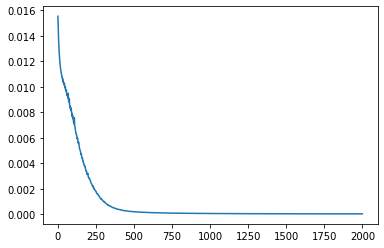

In [55]:
plt.plot(history.history['loss'])

In [21]:
func = K.function([model.get_layer('encoder').input, K.learning_phase()], [model.layers[-1].output])
enc = Model(inputs=model.input, outputs=model.get_layer('pre_encoder').output)

In [64]:
y_test = y_train[np.random.randint(334)]

In [ ]:
res = model.predict(np.expand_dims(y_test, axis=0))

In [ ]:
midi.samples_to_midi(res, '/results/autoencoder_source.mid', 16)
midi.samples_to_midi(res, '/results/autoencoder_result.mid', 16)